Install Dependencies 

In [2]:
!pip3 install tensorflow==2.17.0 opencv-python matplotlib

Import Dependencies

In [3]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

set GPU Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpusGrowth = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpusGrowth: 
    tf.config.experimental.set_memory_growth(gpu, True)

create folder structures

In [6]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [16]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

2. Collect Positives and Anchors 

Untar All the labeled faces in the dataset

In [17]:
# Uncompress Tar GZ Labelled Faces in the dataset
!tar -xf lfw.tgz

In [18]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

Collect the Positive and Anchor Classes

In [31]:
# Import uuid library to generate unique image names
import uuid

In [32]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/f52ee99c-7c24-11ef-91f8-265388ce8bcc.jpg'

In [50]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame = frame[500:1300, 500:1300, :]
    frame = cv2.flip(frame, 1)  # Flip horizontally and vertically
    
# Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [ ]:
plt.imshow(frame[120:120+250,200:200+250, :])

Data Augmentation

In [21]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data


In [22]:
import os
import uuid

In [31]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [56]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

Now We Load and PReprocess Images

Getting te Image Directories

In [44]:
anchor = tf.data.Dataset.list_files(ANC_PATH+"/*.jpg").take(4000)
positive = tf.data.Dataset.list_files(POS_PATH+"/*.jpg").take(4000)
negative = tf.data.Dataset.list_files(NEG_PATH+"/*.jpg").take(4000)

In [45]:
dir_test = anchor.as_numpy_iterator()

In [46]:
print(dir_test.next())

b'data/anchor/1dc3b87e-7dce-11ef-b03d-265388ce8bcc.jpg'


PreProcessing, We Scale and Resize

In [47]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (105,105))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [48]:
img = preprocess('data/anchor/9c9fe69e-7c44-11ef-91f8-265388ce8bcc.jpg')

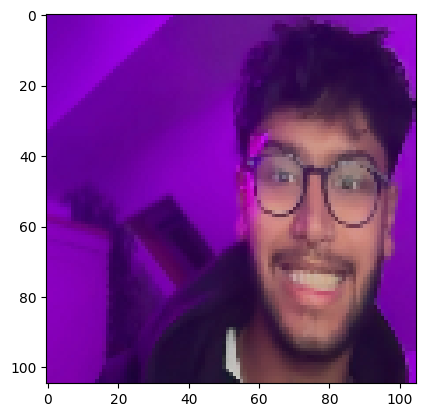

In [49]:
plt.imshow(img)

In [50]:
img.numpy().max() 

0.91708016

In [51]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

Creating Labelled DataSet

In [52]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

samples = data.as_numpy_iterator()

In [53]:
exampple = samples.next()

NameError: name 'samples' is not defined

In [54]:
exampple

NameError: name 'exampple' is not defined

Build Train and Test Partition

In [55]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [56]:
res = preprocess_twin(*exampple)

NameError: name 'exampple' is not defined

In [57]:
plt.imshow(res[1])

NameError: name 'res' is not defined

In [58]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [59]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [60]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

Model Engineering

Build Embedding Layer

In [61]:
inp = Input(shape=(105,105,3), name='input_image')

In [62]:
 c1 = Conv2D(64, (10,10), activation='relu')(inp)


In [63]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [64]:
#Second
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)


In [65]:
#Third
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [66]:
#Final
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [67]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [68]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
def make_embedding():

    inp = Input(shape=(105,105,3), name='input_image')
    #First
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    #Second
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    #Third
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    #Final
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=inp, outputs=d1, name='embedding')

In [70]:
embedding = make_embedding()

In [71]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

Building Distance Layer

In [72]:
#Siamese Distance Class
class L1Dist(Layer):

    #Init Inheritience Method
    def __init__(self, **kwargs):
        super().__init__()

    # similarity calculation
    def call(self,inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)
    

In [73]:
l1 = L1Dist()

In [74]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

Make Siamese Model

In [75]:
# Anchor Image
input_image = Input(name='input_img', shape=(105,105,3))

#Validation Image
validation_image = Input(name='validation_img', shape=(105,105,3))

In [76]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [77]:
siamese_layer = L1Dist()

In [78]:
distances = siamese_layer([inp_embedding, val_embedding])

In [79]:
classifier = Dense(1, activation='sigmoid')(distances)

In [80]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_48>

In [81]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [82]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
def make_siamese_model():

    # Anchor Image
    input_image = Input(name='input_img', shape=(105,105,3))

    #Validation Image
    validation_image = Input(name='validation_img', shape=(105,105,3))

    #Combining the Siamese Distance Components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer([embedding(input_image), embedding(validation_image)])

    #Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
    
    
    

In [84]:
siamese_model = make_siamese_model()

In [85]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_4 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

Training

Setup Loss and Optimizer

In [86]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [87]:
opt = tf.keras.optimizers.Adam(1e-4)

Make CheckPoints

In [88]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

Building the Train Step Function

In [89]:
test_batch = train_data.as_numpy_iterator()

In [90]:
batch_1 = test_batch.next()

In [91]:
x = batch_1[:2]

In [92]:
y = batch_1[2]

In [93]:
y

array([1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.],
      dtype=float32)

In [101]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape :

        # Get All Images

        X = batch[:2]
        y = batch[2]

        # Forward Pass and Calculating Losses
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)

    #Calculate all gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
     # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss
    
        

Build Training Loop

In [102]:
from tensorflow.keras.metrics import Recall, Precision

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        try:
            # Loop through each batch
            for idx, batch in enumerate(data):
                # Run train step here
                loss = train_step(batch)
                yhat = siamese_model.predict(batch[:2])
                r.update_state(batch[2], yhat)
                p.update_state(batch[2], yhat)
                progbar.update(idx + 1)

            # Print loss and metrics
            

        except tf.errors.OutOfRangeError:
            # Catch the OutOfRangeError and continue training
            print("Dataset exhausted. Continuing training.")
            continue
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

Training the Model

In [103]:
EPOCHS = 50
batch_size= 27

In [104]:
train(train_data, EPOCHS)


 Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
  3/350 ━━━━━━━━━━━━━━━━━━━━ 14:14 2s/step

KeyboardInterrupt: 

Evaluating Models 

Import Metrics

In [203]:
from tensorflow.keras.metrics import Precision, Recall

In [204]:
#Getting the Test Data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [212]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


In [215]:
# We then post process the results
res = []

for prediction in y_hat:
    if prediction > 0.5 :
        res.append(1)
    else:
        res.append(0)

res

[1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]

In [216]:
y_true

array([1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

Calculate Metrics

In [217]:
# Creating a metric object 
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [218]:
# Creating a metric object 
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

Visualise the Results


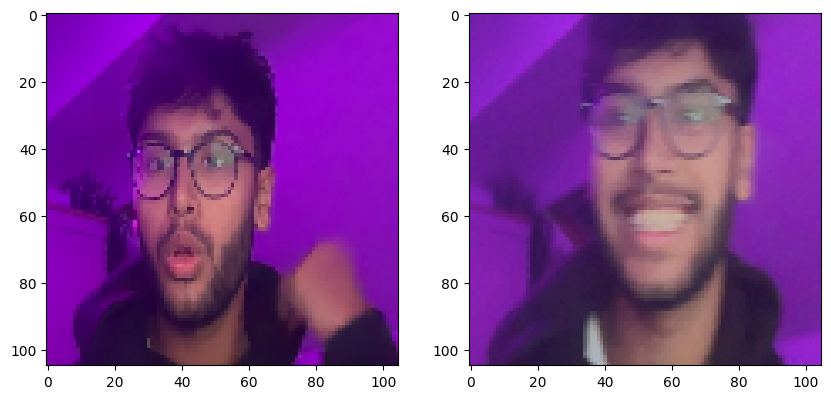

In [221]:
# CORRECT VERIFICATION
# Set plot size 
plt.figure(figsize=(10,8))
# First
plt.subplot(1,2,1)
plt.imshow(test_input[2])
# Second
plt.subplot(1,2,2)
plt.imshow(test_val[2])

plt.show()

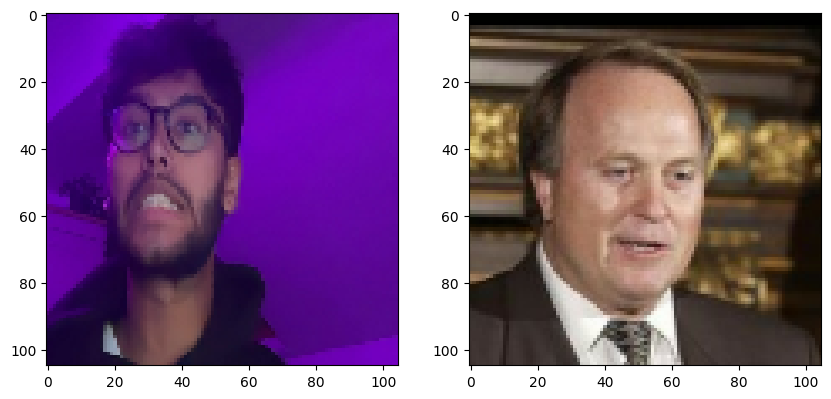

In [223]:
# INCORRECT VERIFICATION
# Set plot size 
plt.figure(figsize=(10,8))
# First
plt.subplot(1,2,1)
plt.imshow(test_input[1])
# Second
plt.subplot(1,2,2)
plt.imshow(test_val[1])

plt.show()

In [9]:
#Saving all the weights 
siamese_model.save('siamesemodel.h5')

NameError: name 'siamese_model' is not defined

In [15]:
siamese_model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [231]:
# Lets make some predictions with the model we reloaded
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


array([[1.0000000e+00],
       [1.2715318e-16],
       [9.9993807e-01],
       [1.8740535e-14],
       [9.9999881e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [3.2376061e-17],
       [1.3956380e-14],
       [5.0193634e-17],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9976617e-01]], dtype=float32)

In [8]:
siamese_model.summary()
# We use this to view the Summary

NameError: name 'siamese_model' is not defined

## Real Time Test 


### Verification Function

In [18]:
def verify(model, detection_threshold, verification_threshold):

    # Results Array
    results= []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Makingf the Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Thresholds are the metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    # Verification Thresholds are the proportion of + prediction / total + samples

    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold

    return results, verified

## OpenCV Verification at Real Time

In [19]:


cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[500:1300, 500:1300, :]
    frame = cv2.flip(frame, 1)  # Flip horizontally and vertically
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━

TypeError: 'NoneType' object is not subscriptable